In [1]:
import random
from collections import namedtuple
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from itertools import count
import math
from IPython import display
import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

In [2]:
# plt.ion()

In [3]:
%matplotlib inline

In [4]:
env = gym.make('CartPole-v0')

In [5]:
env.reset()

array([-0.04595387, -0.03358537,  0.00970846, -0.03367069])

In [6]:
screen = env.render(mode='rgb_array')

In [7]:
screen.shape

(400, 600, 3)

In [8]:
# ?env.render

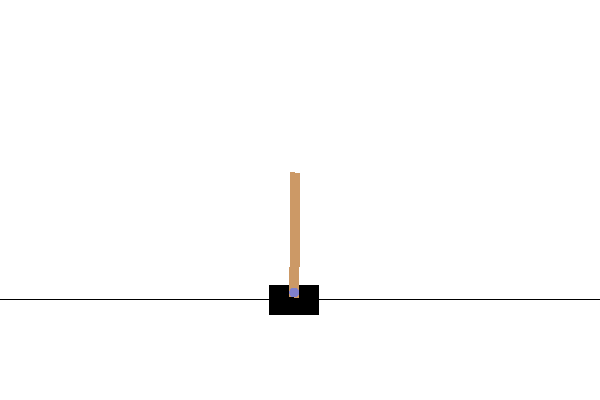

In [9]:
Image.fromarray(screen)

In [10]:
# import matplotlib
# matplotlib.get_backend()
# %matplotlib inline
# matplotlib.use('module://ipykernel.pylab.backend_inline')

In [11]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [12]:
# class DQN(nn.Module):

#     def __init__(self):
#         super(DQN, self).__init__()
#         self.fc1 = nn.Linear(4,16)
#         self.fc2 = nn.Linear(16,16)
#         self.fc3 = nn.Linear(4,16)

#         self.conv1 = nn.Linear(3, 16, kernel_size=5, stride=2)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
#         self.bn3 = nn.BatchNorm2d(32)
#         self.head = nn.Linear(448, 2)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.relu(self.bn3(self.conv3(x)))
#         return self.head(x.view(x.size(0), -1))

In [108]:
# model = nn.Sequential(nn.Linear(4,16), nn.ReLU(), 
#                      nn.Linear(16,32), nn.ReLU(), 
#                      nn.Linear(32,16), nn.ReLU(), 
#                      nn.Linear(16,2))

 

In [126]:
pred = model(Variable(torch.rand(1,4)))
print(pred)
pred.data.max(1)[1].view(1, 1)

Variable containing:
1.00000e-02 *
 -2.9741 -6.5865
[torch.FloatTensor of size 1x2]




 0
[torch.LongTensor of size 1x1]

In [107]:
model

Sequential (
  (0): Linear (4 -> 16)
  (1): ReLU ()
  (2): Linear (16 -> 2)
)

In [71]:
env.reset()

array([-0.02228761,  0.03870131,  0.01607648,  0.02830659])

In [72]:
optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(10000)

In [127]:
BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

In [128]:
steps_done = 0

In [129]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return model(Variable(state, volatile=True).float()).data.max(1)[1].view(1, 1)
    else:
        return torch.LongTensor([[random.randrange(2)]])

In [130]:
episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [131]:
# memory.sample(1)

In [132]:
last_sync = 0


def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))

    # We don't want to backprop through the expected action values and volatile
    # will save us on temporarily changing the model parameters'
    # requires_grad to False!
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]),
                                     volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = model(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE).float())
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    # Now, we don't want to mess up the loss with a volatile flag, so let's
    # clear it. After this, we'll just end up with a Variable that has
    # requires_grad=False
    next_state_values.volatile = False
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    print(loss.data.numpy()[0])

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [133]:
# batch = Transition(*zip(*memory.sample(BATCH_SIZE)))

In [134]:
# batch.state

In [135]:
# batch.reward

In [136]:
steps_done = 0

In [137]:
steps_done

0

In [137]:
num_episodes = 500
for i_episode in range(num_episodes):
    # Initialize the environment and state
    last_obs = env.reset()
    current_obs, reward, done, _ = env.step(0)
    state = torch.from_numpy(current_obs-last_obs).float().unsqueeze(0)
#     init_action = random.randint(0,1)
#     for _ in range(5):
#         env.step(init_action)
#     last_screen = get_screen()
#     current_screen = get_screen()
#     state = current_screen - last_screen
    countdown = 50
    
    for t in count():
        # Select and perform an action
        action = select_action(state)
        print(action)
        last_obs = current_obs
        current_obs, reward, done, _ = env.step(action[0, 0])
        env.render()
        next_state = torch.from_numpy(current_obs-last_obs).float().unsqueeze(0)
        reward = torch.Tensor([reward])
        
        if done:
            next_state = None
        
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
env.render(close=True)
env.close()
plt.ioff()
plt.show()

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
memory.sample(3)

In [38]:
action


 0
[torch.LongTensor of size 1x1]

In [ ]:
# for
# env.step()

In [ ]:
env.re

In [ ]:
obs = env.reset()
for _ in range(0):
    env.step(0)
countdown = 50
for t in count():
    # Select and perform an action
    state = torch.from_numpy(obs).float().unsqueeze(0)
    action = select_action(state)
    obs, reward, done, _ = env.step(action[0, 0])
    env.render()
#     print(action)
#     next_state = torch.from_numpy(obs).float().unsqueeze(0)
    
    if done:
        countdown-=1
    
    if countdown<=0:
        break

print(t-countdown)

In [ ]:
plt.imshow(state.squeeze().numpy().transpose((1,2,0)))